# Imports

In [1]:
!git clone https://github.com/MrARVO/GraphZ.git

fatal: destination path 'GraphZ' already exists and is not an empty directory.


In [2]:
!git clone https://github.com/Nazar1997/Sparse_vector.git sparse_vector

fatal: destination path 'sparse_vector' already exists and is not an empty directory.


In [3]:
# Data loading
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm


# Graph dataset
# from torch_geometric.loader import DataLoader
# from torch_geometric.data import Dataset, Data

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold


# GNN Model
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch_geometric.nn import GCNConv, GraphConv, GATConv, GATv2Conv, SAGEConv


# Sparse vector
from sparse_vector.sparse_vector import SparseVector

In [4]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Data loading

In [5]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]

features = [i[:-4] for i in os.listdir('GraphZ/data/hg19_features/')]
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in features if (i.split('_')[0] in groups)]

In [6]:
def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'GraphZ/data/hg19_dna/') if f"{chrom}_" in i])
    return ''.join([load(f"GraphZ/data/hg19_dna/{file}") for file in files])

In [7]:
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
ZDNA = load('GraphZ/data/hg19_zdna/ZDNA.pkl')

DNA_features = {feture: load(f'GraphZ/data/hg19_features/{feture}.pkl')
                for feture in tqdm(feature_names)}

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1054 [00:00<?, ?it/s]

DeepZ (original) on 1000

GRU

GraphZSAGE

# Data selection 

In [8]:
from joblib import Parallel, delayed, dump, load
from matplotlib import pyplot as plt
import torch
from torch.utils import data
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold

In [9]:
class Dataset(data.Dataset):
    def __init__(self, chroms, features,
                 dna_source, features_source,
                 labels_source, intervals, lrp_feat=[]):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels_source = labels_source
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))
        self.lrp_feat = lrp_feat

    def __len__(self):
        return len(self.intervals)

    def __getitem__(self, index):
        interval = self.intervals[index]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        dna_OHE = self.le.transform(list(self.dna_source[chrom][begin:end].upper()))

        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            feature_matr.append(source[chrom][begin:end])
        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T/1000)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)
        y = self.labels_source[interval[0]][interval[1]: interval[2]]
        if len(self.lrp_feat) > 0:
            X = X[:,np.sort(lrp_feat)]

        return (X, y)



In [146]:
width = 1000

np.random.seed(10)

ints_in = []
ints_out = []

for chrm in chrom_names:
    for st in trange(0, ZDNA[chrm].shape - width, width):
        interval = [st, min(st + width, ZDNA[chrm].shape)]
        if ZDNA[chrm][interval[0]: interval[1]].any():
            ints_in.append([chrm, interval[0], interval[1]])
        else:
            ints_out.append([chrm, interval[0], interval[1]])

ints_in = np.array(ints_in)
ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in) * 3, replace=False)]

100%|██████████| 16/16 [00:00<00:00, 11015.90it/s]


In [147]:
params = {'batch_size':16,
          #'num_workers':4,
          'shuffle':True}

In [148]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, recall_score
from IPython.display import clear_output
class DeepZ(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
                    nn.Conv2d(1, 3, kernel_size=(3, 3), padding=1),
                    nn.BatchNorm2d(3),
                    nn.ReLU(),
                    nn.Conv2d(3, 3, kernel_size=(5, 5), padding=2),
                    nn.ReLU(),
                    nn.Conv2d(3, 1, kernel_size=(3, 3), padding=1),
                    nn.BatchNorm2d(1),
                    nn.ReLU(),
                    nn.Dropout(0.25),
                    nn.Linear(1058, 500),
                    nn.Dropout(0.25),
                    nn.ReLU(),
                    nn.Linear(500, 2)
        )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, width, 1058)
        x = self.seq(x)
        x = torch.squeeze(x)
        x = F.log_softmax(x, dim=-1)
        return x
# class DeepZ(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.hidden_dim = 500
#     self.n_layers = 2
#     self.rnn = nn.LSTM(1058, 500, 2, bidirectional = True)
#     self.seq = nn.Sequential(nn.Dropout(0.5), nn.Linear(1000, 500), nn.Sigmoid(), nn.Dropout(0.5), nn.Linear(500, 2))
#   def forward(self, x):
#     x, (h_n, c_n) = self.rnn(x)
#     x = self.seq(x)
#     return F.log_softmax(x, dim = -1)

# Train and test

In [49]:
def loss_func(output, y_batch):
    return torch.nn.NLLLoss()(torch.transpose(output, 2, 1), y_batch)



def train_epoch(model, optimizer):
    loss_log, acc_log, roc_auc_log, f1_log = [], [], [], []
    model.train()
    for X_batch, y_batch in loader_train:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
        optimizer.zero_grad()
        output = model(X_batch)
        pred = torch.argmax(output, dim=2)
        y_pred = nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten()
        if np.std(y_batch.cpu().numpy().flatten()) == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())
        f1_log.append(f1_score(y_batch.cpu().numpy().flatten(),
                         pred.cpu().numpy().flatten()))
        roc_auc_log.append(roc_auc)
        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        loss = loss_func(output, y_batch)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log, roc_auc_log, f1_log

def test(model):
    loss_log, acc_log, roc_auc_log, f1_log = [], [], [], []
    model.eval()
    means = []
    for X_batch, y_batch in loader_test:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda().long()
        output = model(X_batch)
        means.append(y_batch.sum().cpu() / (1.0 * y_batch.shape[0]))
        pred = torch.argmax(output, dim=2)
        if np.std(y_batch.cpu().numpy().flatten()) == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())
        
        f1 = f1_score(y_batch.cpu().numpy().flatten(),
                                  pred.cpu().numpy().flatten())
        if f1 == 0.0 and torch.all(y_batch == 0) and torch.all(pred == 0):
            print("all zeros")
        else:
            f1_log.append(f1)
        roc_auc_log.append(roc_auc)
        acc = torch.mean((pred == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        loss = loss_func(output, y_batch)
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log, roc_auc_log, f1_log

def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=20):
    plt.figure(figsize=(epoch_to_show, 4))
    plt.title(title)    
    
    epoch_num = len(valid_history)
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)
    
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, (epoch_to_show+1)*BatchSize), 
             train_history[-(epoch_to_show+1)*BatchSize:], c='red', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='green', label='test')
    
    plt.ylim((0, 1))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2), 
              np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    if (epoch_num == 20):
        name = "final" + str(version) + ".png"
        plt.savefig(name)
    
def train(model, opt, n_epochs):
    train_log, train_acc_log, train_auc_log, train_f1_log = [], [], [], []
    val_log,   val_acc_log,   val_auc_log, val_f1_log   = [], [], [], []
    
    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch + 1, n_epochs))
        train_loss, train_acc, train_auc, train_f1 = train_epoch(model, opt)
        val_loss, val_acc, val_auc, val_f1 = test(model)
        
        BatchSize = len(train_loss)
        
        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        train_auc_log.extend(train_auc)
        train_f1_log.extend(train_f1)

        val_log.append(np.mean(val_loss))
        val_acc_log.append(np.mean(val_acc))
        val_auc_log.append(np.mean(val_auc))
        val_f1_log.append(np.mean(val_f1))
        
#         raise BaseException
        
        if (epoch % 1) == 0:
            clear_output()
            plot_history(train_log,     val_log,     'Loss',     BatchSize)    
            plot_history(train_acc_log, val_acc_log, 'Accuracy', BatchSize)
            plot_history(train_auc_log, val_auc_log, 'Auc',      BatchSize)
            plot_history(train_f1_log, val_f1_log,   'F1',       BatchSize)
            print("Epoch {} AUC = {:.2%}".format(epoch+1, val_auc_log[-1]))
            print("Epoch {} accuracy = {:.2%}".format(epoch+1, val_acc_log[-1]))
            print("Epoch {} F1 = {:.2%}".format(epoch+1, val_f1_log[-1]))
            
           
    print("Final AUC: {:.2%}".format(val_auc_log[-1]))
    print("Final F1: {:.2%}".format(val_f1_log[-1]))
    print("Final Accuracy: {:.2%}".format(val_acc_log[-1]))
    results.append([val_auc_log[-1], val_f1_log[-1], val_acc_log[-1]])
    

In [15]:
torch.cuda.empty_cache()

# Validation

In [16]:
from sklearn.model_selection import train_test_split

# validation on datasets with different and small positive class

In [149]:
ints_in_train, ints_in_test = train_test_split(ints_in, test_size=0.2, random_state=42)

In [150]:
ints_out_train, ints_out_test = train_test_split(ints_out, test_size=0.2, random_state=42)

In [151]:
def to_intervals(ins):
    intervals = [[inter[0], int(inter[1]), int(inter[2])] for inter in ins]
    return intervals

In [152]:
same_test = np.vstack((ints_in_test, ints_out_test))
same_test = to_intervals(same_test)

In [153]:
def split_to_n(n, ds):
    split_size = len(ds) // n
    res = [to_intervals((ds[i:i + split_size])) for i in range(0, len(ds), split_size)]
    if (len(res) > n - 1):
        res[n - 1] = np.vstack((res[n - 1], res[-1]))
        del res[-1]
    return res

In [154]:
spl = 4
ins = split_to_n(spl, ints_in_train) 
outs = split_to_n(spl, ints_out_train)

In [35]:
datasets = []
for i in range(spl):
    datasets.append(to_intervals(np.vstack((ins[i] ,outs[i]))))

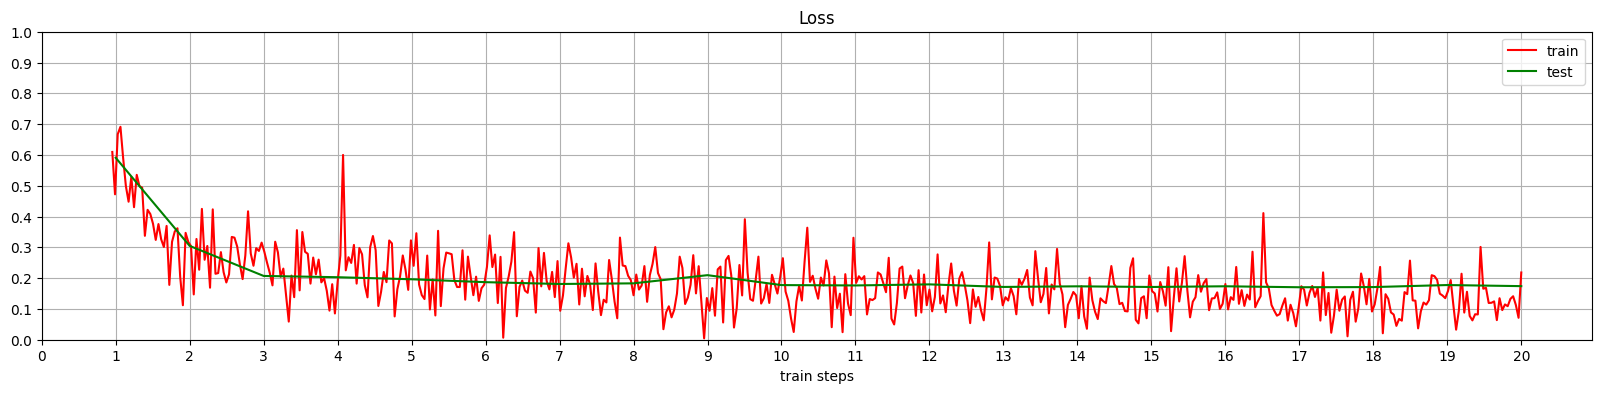

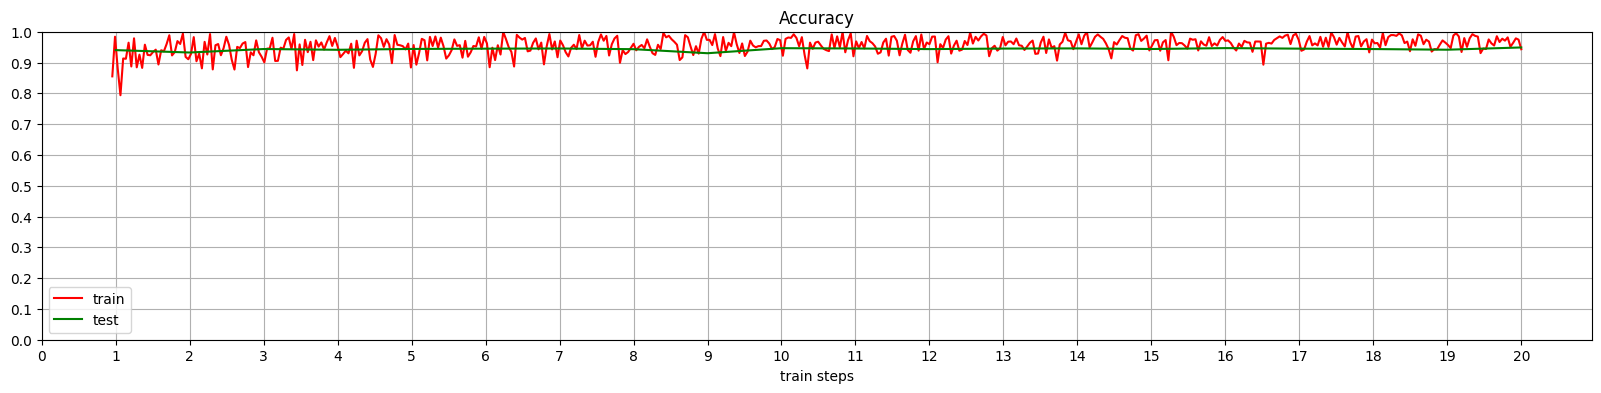

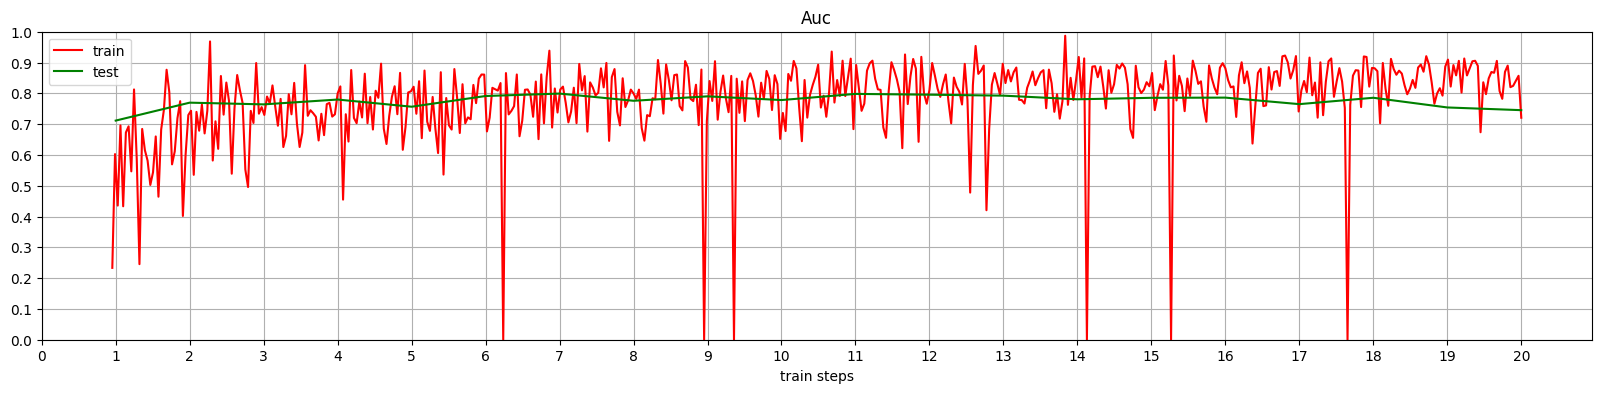

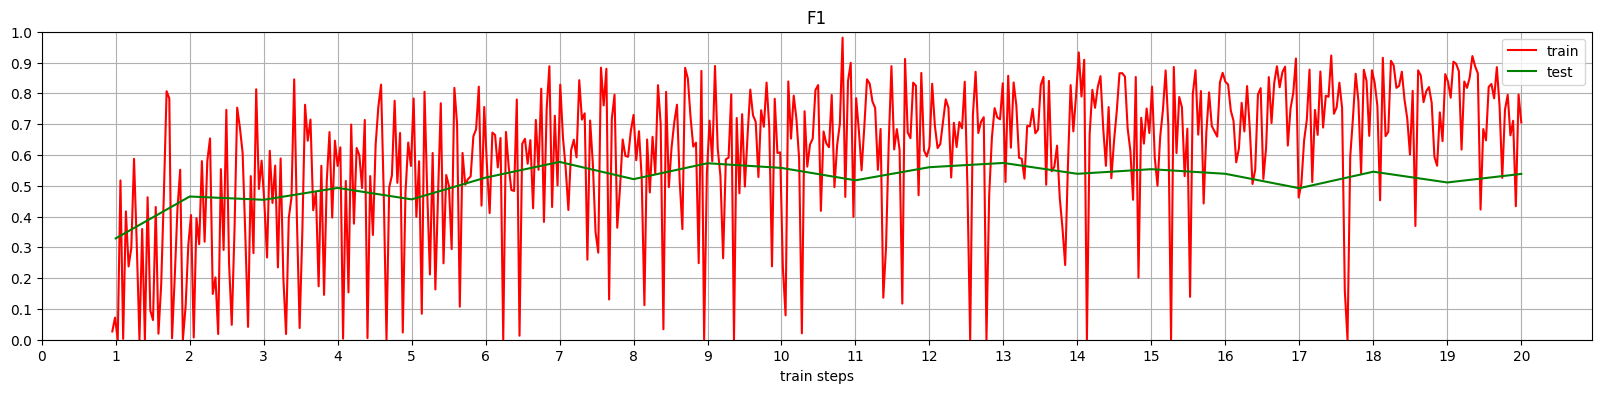

Epoch 20 AUC = 74.53%
Epoch 20 accuracy = 94.89%
Epoch 20 F1 = 53.83%
Final AUC: 74.53%
Final F1: 53.83%
Final Accuracy: 94.89%


In [38]:
results = []
version = 1
for dt in datasets:
    np.random.seed(42)
    set_random_seed(42)
    torch.cuda.empty_cache()
    model = DeepZ()
    model = model.cuda()
    opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)
    train_dataset = Dataset(chrom_names, feature_names,
                       DNA, DNA_features,
                       ZDNA, dt, lrp_feat = [])

    loader_train = data.DataLoader(train_dataset, **params)
    test_dataset = Dataset(chrom_names, feature_names,
                      DNA, DNA_features,
                      ZDNA, same_test, lrp_feat = [])
    loader_test = data.DataLoader(test_dataset, **params)
    
    train(model, opt, 20)
    torch.save(model.state_dict(), f"trained_dataset_{version}.pth")
    version += 1

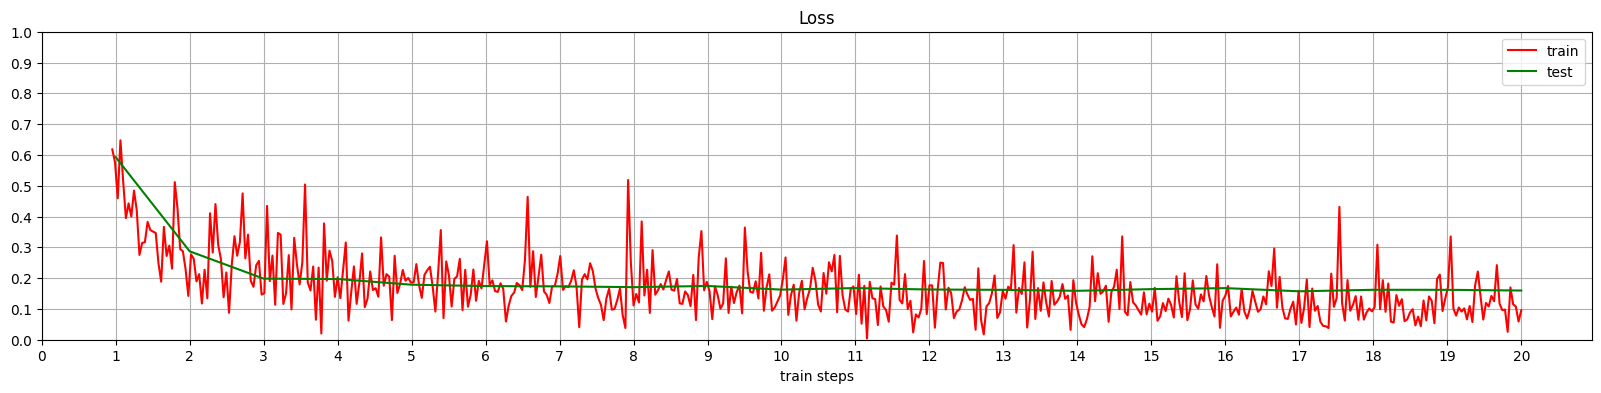

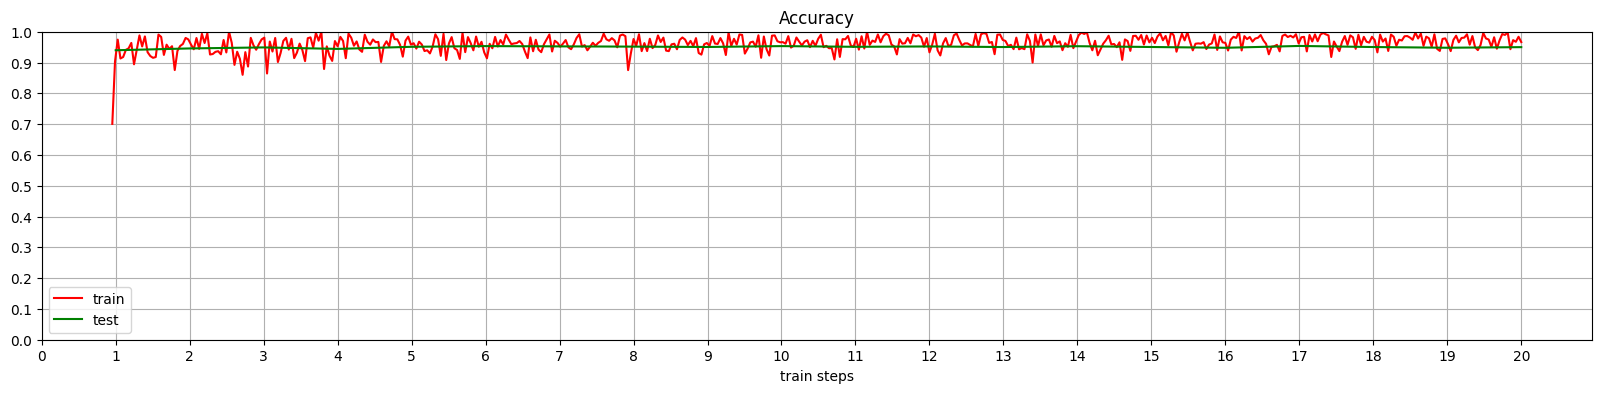

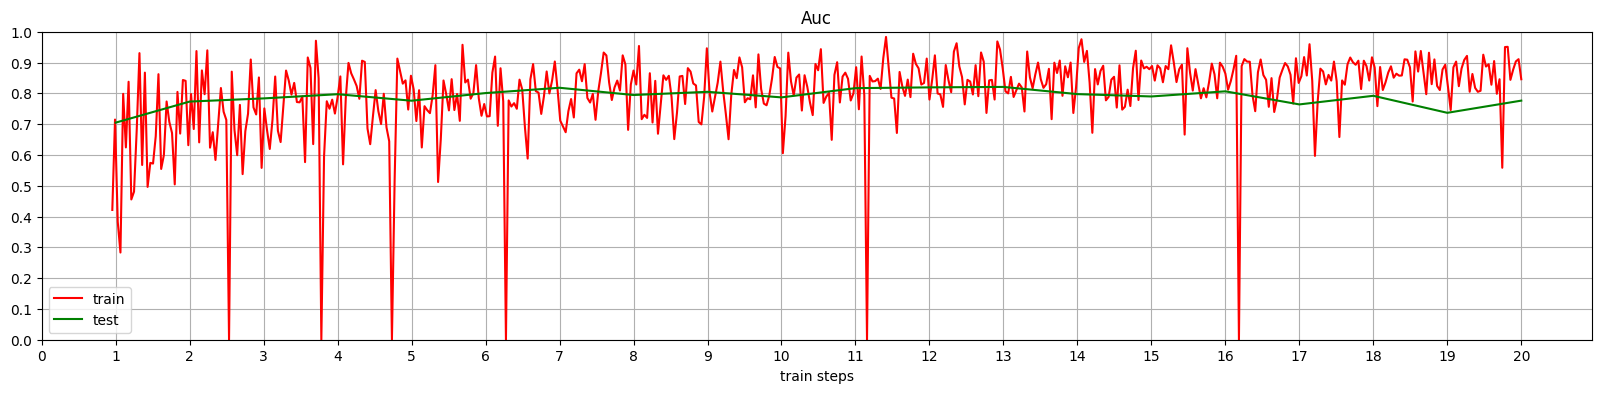

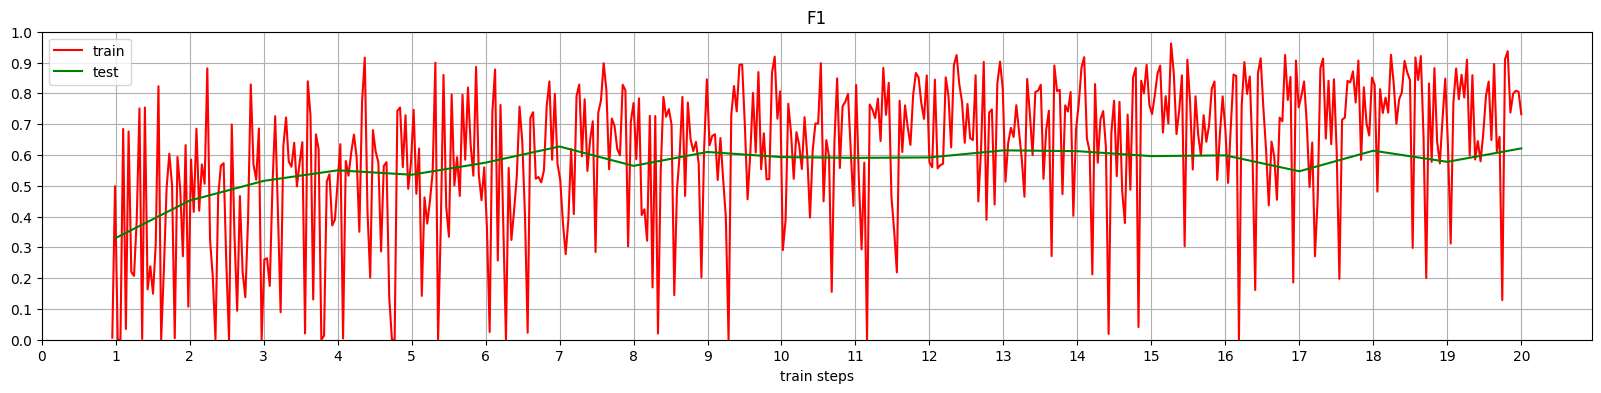

Epoch 20 AUC = 77.63%
Epoch 20 accuracy = 94.99%
Epoch 20 F1 = 62.12%
Final AUC: 77.63%
Final F1: 62.12%
Final Accuracy: 94.99%


In [39]:
np.random.seed(42)
set_random_seed(42)
torch.cuda.empty_cache()
model = DeepZ()
model = model.cuda()
opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)
train_dataset = Dataset(chrom_names, feature_names,
                   DNA, DNA_features,
                   ZDNA, datasets[2], lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
test_dataset = Dataset(chrom_names, feature_names,
                  DNA, DNA_features,
                  ZDNA, same_test, lrp_feat = [])
loader_test = data.DataLoader(test_dataset, **params)

train(model, opt, 20)
torch.save(model.state_dict(), f"trained_dataset_{3}.pth")

# validation on datasets with same positive class

In [155]:
datasets = []
for i in range(spl):
    datasets.append(to_intervals(np.vstack((ints_in_train ,outs[i]))))

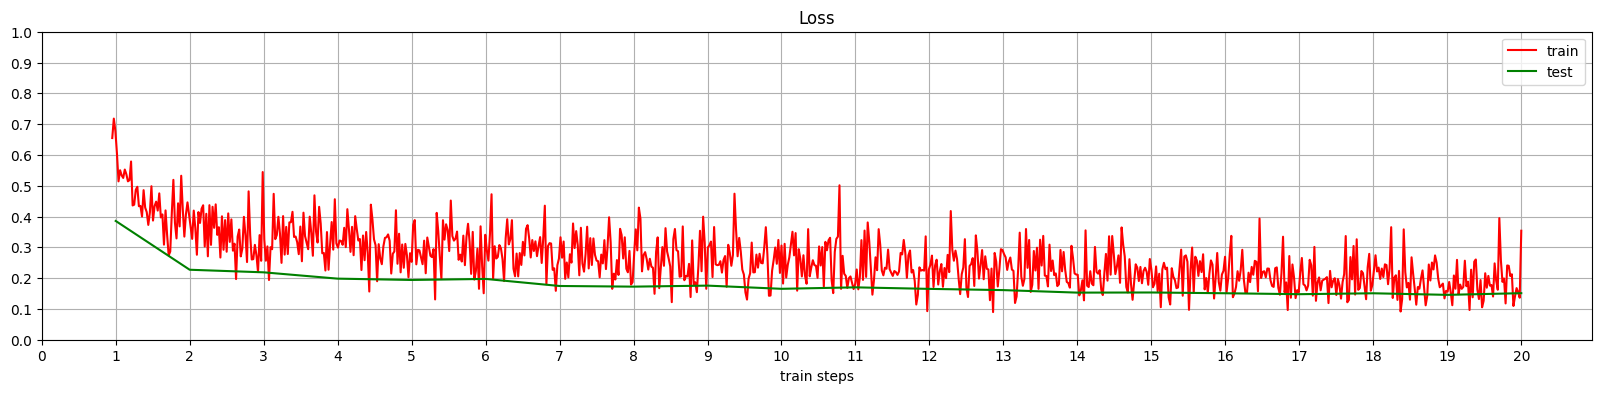

<Figure size 640x480 with 0 Axes>

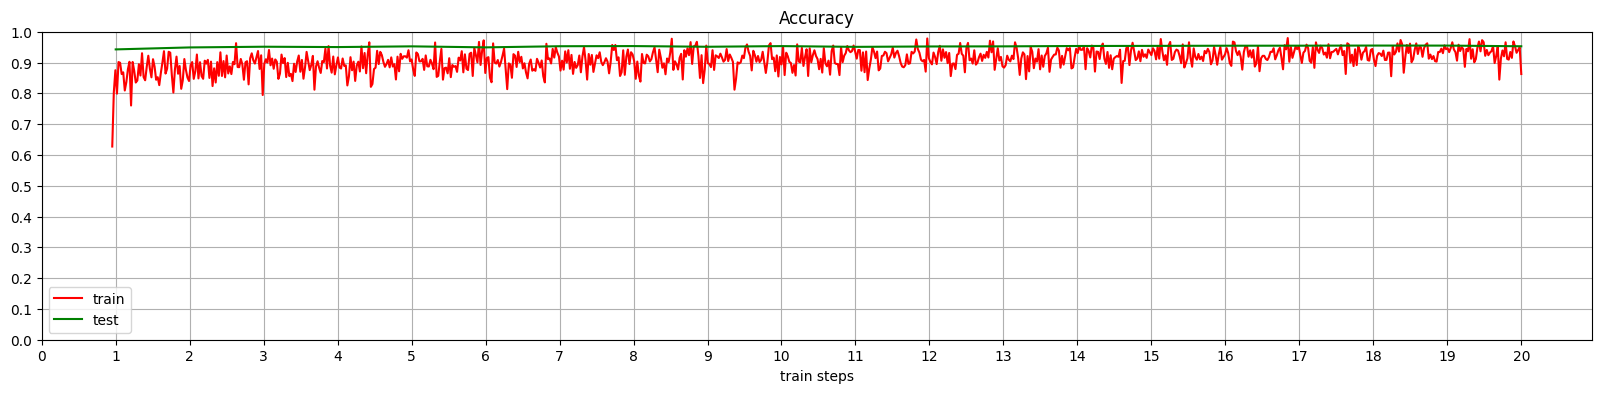

<Figure size 640x480 with 0 Axes>

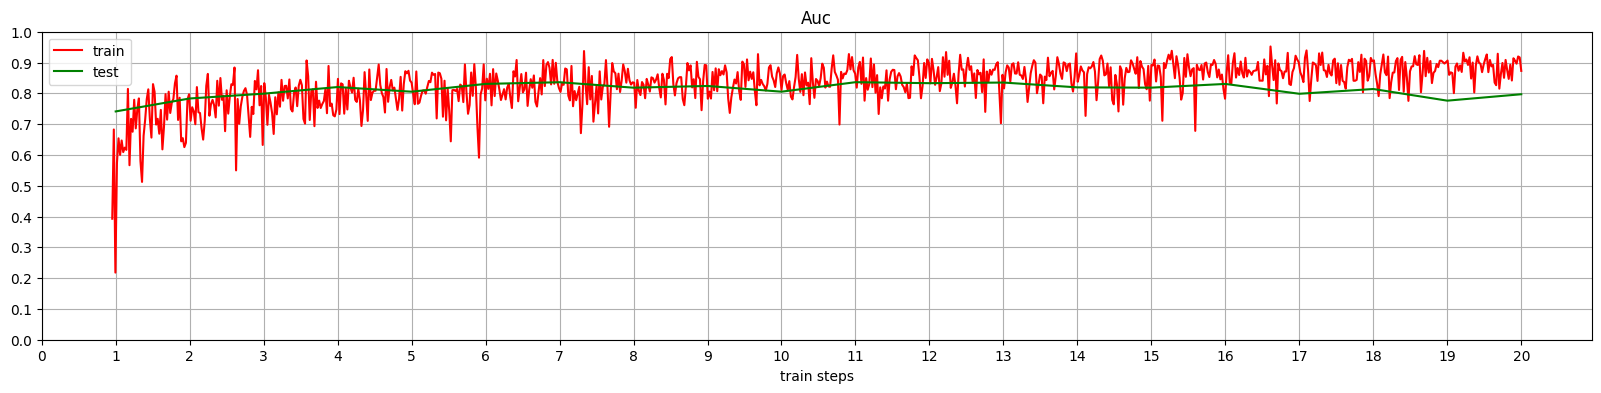

<Figure size 640x480 with 0 Axes>

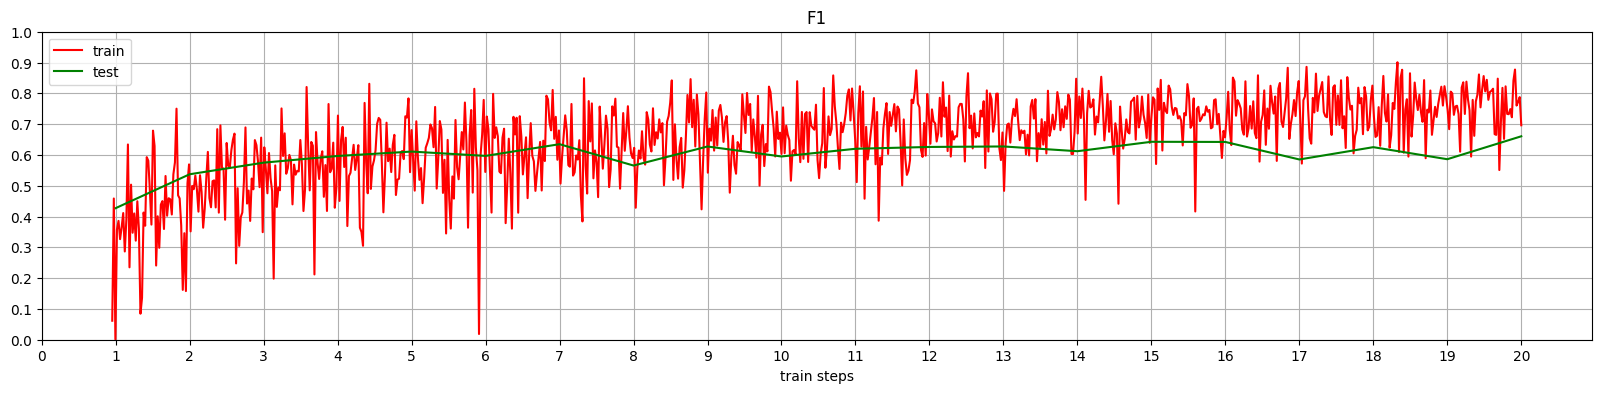

Epoch 20 AUC = 79.70%
Epoch 20 accuracy = 95.28%
Epoch 20 F1 = 66.05%
Final AUC: 79.70%
Final F1: 66.05%
Final Accuracy: 95.28%


<Figure size 640x480 with 0 Axes>

In [50]:
results = []
version = 1
for dt in datasets:
    np.random.seed(42)
    set_random_seed(42)
    torch.cuda.empty_cache()
    model = DeepZ()
    model = model.cuda()
    opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)
    train_dataset = Dataset(chrom_names, feature_names,
                       DNA, DNA_features,
                       ZDNA, dt, lrp_feat = [])

    loader_train = data.DataLoader(train_dataset, **params)
    test_dataset = Dataset(chrom_names, feature_names,
                      DNA, DNA_features,
                      ZDNA, same_test, lrp_feat = [])
    loader_test = data.DataLoader(test_dataset, **params)
    
    train(model, opt, 20)
    torch.save(model.state_dict(), f"trained_dataset_same_pos_{version}.pth")
    version += 1


In [53]:
for k in results:
    print("Auc:", k[0], " F1:", k[1], " Acc:", k[2])

Auc: 0.7894760827792286  F1: 0.6300998546921932  Acc: 0.95406425
Auc: 0.7927897890958848  F1: 0.6196402471695742  Acc: 0.95326614
Auc: 0.7901359537972048  F1: 0.6428952566723184  Acc: 0.9548182
Auc: 0.797015119122813  F1: 0.6604962742911435  Acc: 0.95277727


In [54]:
model_1 = DeepZ()
model_1.load_state_dict(torch.load("trained_dataset_same_pos_1.pth"))
model_1.eval()

DeepZ(
  (seq): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=1058, out_features=500, bias=True)
    (10): Dropout(p=0.25, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=500, out_features=2, bias=True)
  )
)

In [55]:
model_2 = DeepZ()
model_2.load_state_dict(torch.load("trained_dataset_same_pos_2.pth"))
model_2.eval()

DeepZ(
  (seq): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=1058, out_features=500, bias=True)
    (10): Dropout(p=0.25, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=500, out_features=2, bias=True)
  )
)

In [56]:
model_3 = DeepZ()
model_3.load_state_dict(torch.load("trained_dataset_same_pos_3.pth"))
model_3.eval()

DeepZ(
  (seq): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=1058, out_features=500, bias=True)
    (10): Dropout(p=0.25, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=500, out_features=2, bias=True)
  )
)

In [57]:
model_4 = DeepZ()
model_4.load_state_dict(torch.load("trained_dataset_same_pos_4.pth"))
model_4.eval()

DeepZ(
  (seq): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Linear(in_features=1058, out_features=500, bias=True)
    (10): Dropout(p=0.25, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=500, out_features=2, bias=True)
  )
)

In [58]:
models = [model_1, model_2, model_3, model_4]

In [125]:
model_predictions = []  

for model in models:
    model.cuda() 
    model_preds = []
    for X_batch, _ in loader_test:
        X_batch = X_batch.cuda()
        output = model(X_batch)
        pred = torch.argmax(output, dim=2)
        model_preds.append(pred.cpu().numpy().flatten())  
    model_predictions.append(np.concatenate(model_preds))

num_models = len(model_predictions)
agreement_matrix = np.zeros((num_models, num_models))

for i in range(num_models):
    for j in range(num_models):
        agreement = np.mean(model_predictions[i] == model_predictions[j])
        agreement_matrix[i, j] = agreement

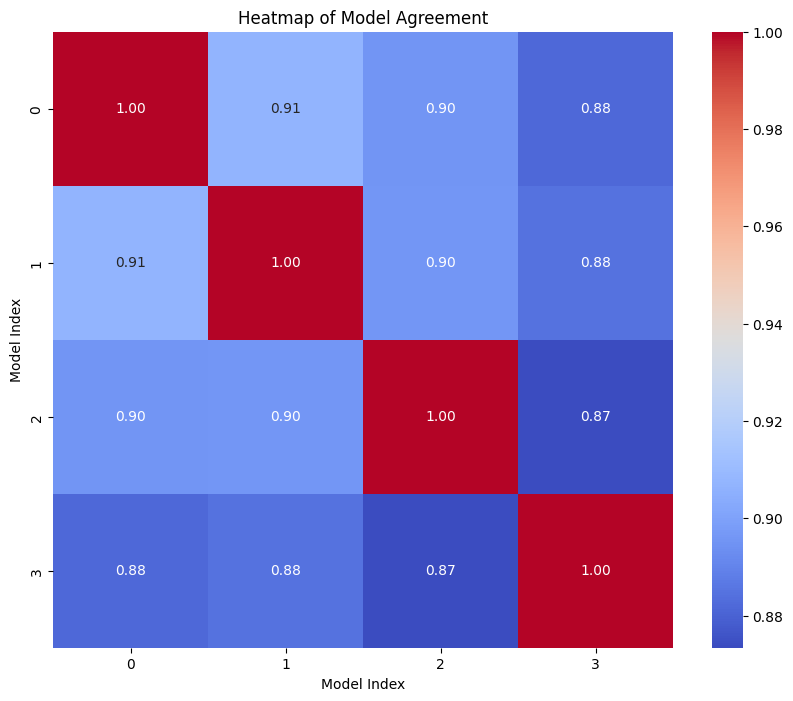

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 8))
sns.heatmap(agreement_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Model Agreement')
plt.xlabel('Model Index')
plt.ylabel('Model Index')
plt.show()


In [118]:
model_predictions_fp = []  

for model in models:
    model.cuda() 
    model_preds_fp = []
    for X_batch, y_batch in loader_test:
        X_batch = X_batch.cuda()
        output = model(X_batch)
        pred = torch.softmax(output, dim=1)
        threshold = 0.01
        pred = pred[..., 1] > threshold
        pred = pred.int()
        model_predictions_fp.append(np.where((pred.cpu().numpy().flatten() == 0) & (y_batch.cpu().numpy().flatten() == 1))) 

agreement_matrix = np.zeros((num_models, num_models))

In [119]:
for i in range(num_models):
    for j in range(i, num_models):
        fp_i = model_predictions_fp[i][0]
        fp_j = model_predictions_fp[j][0]
        fp_agreement = len(np.intersect1d(fp_i,fp_j)) / len(np.union1d(fp_i,fp_j))
        agreement_matrix[i, j] = fp_agreement
        agreement_matrix[j, i] = fp_agreement 

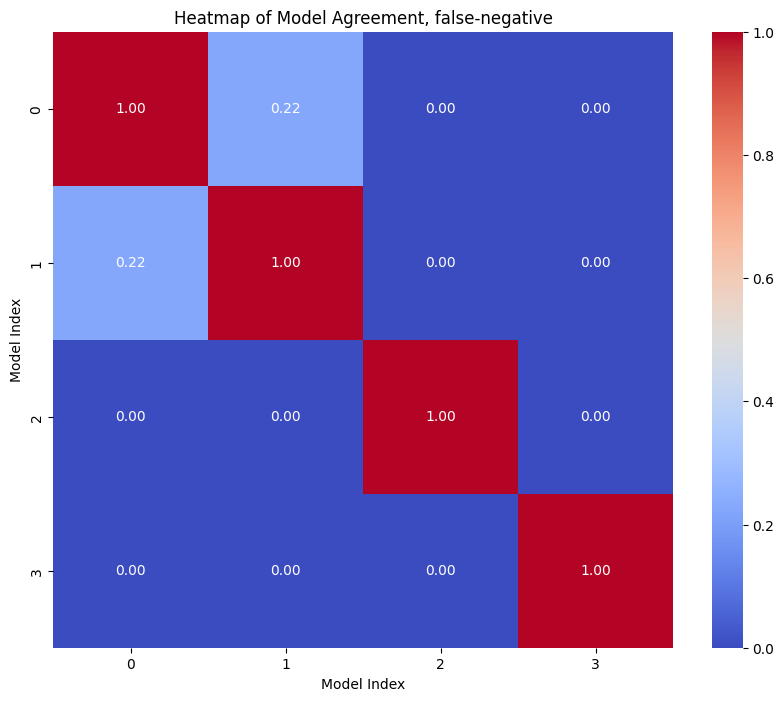

In [120]:
plt.figure(figsize=(10, 8))
sns.heatmap(agreement_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Model Agreement, false-negative')
plt.xlabel('Model Index')
plt.ylabel('Model Index')
plt.show()

In [65]:
model_predictions_fp = []  

for model in models:
    model.cuda() 
    model_preds_fp = []
    for X_batch, y_batch in loader_test:
        X_batch = X_batch.cuda()
        output = model(X_batch)
        pred = torch.argmax(output, dim=2)  
        model_predictions_fp.append(np.where((pred.cpu().numpy().flatten() == 1) & (y_batch.cpu().numpy().flatten() == 0)))  # Move to CPU

agreement_matrix = np.zeros((num_models, num_models))
   

In [108]:
agreement = np.zeros((num_models, num_models))
for i in range(num_models):
    for j in range(i, num_models):
        agreement[i, j] = np.mean(agreement_matrix[i][j])
        agreement[j, i] = np.mean(agreement_matrix[j][i])


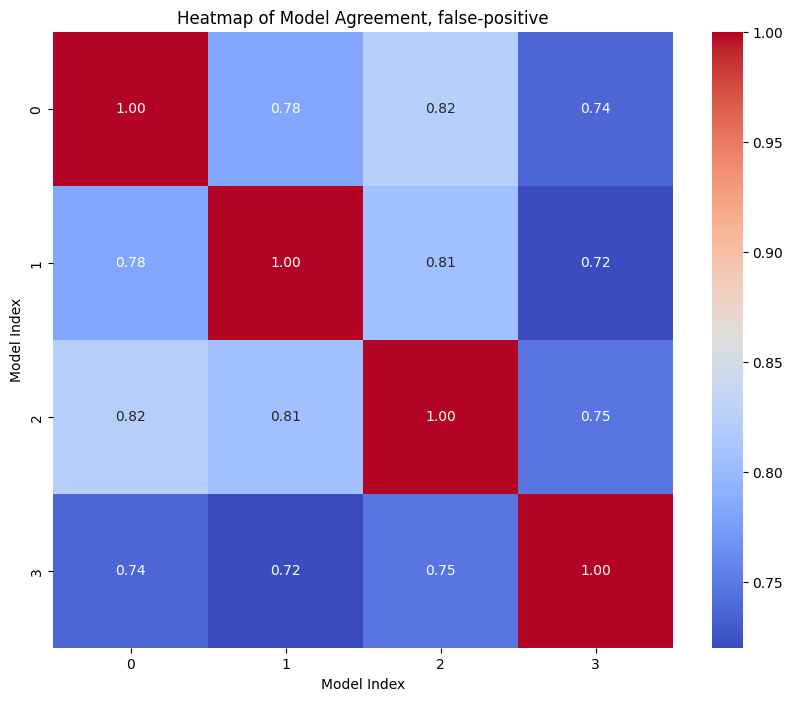

In [109]:
plt.figure(figsize=(10, 8))
sns.heatmap(agreement, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Model Agreement, false-positive')
plt.xlabel('Model Index')
plt.ylabel('Model Index')
plt.show()